# Image segmentation / Сегментация изображений

---

Ильясов Антон Евгеньевич, 411403

---


In the lab work you will work with binary segmentation problem. You goal is predict a mask to a road sign.

You can ask question about lab in the telegram [@ZeinBarhoum](https://t.me/ZeinBarhoum).
Если у вас есть вопросы, то можно спросить [@catharsisnz](https://t.me/catharsisnz).

**Requirements**
1. You did the lab on your own.
2. Conclusions are well-reasoned and valid.
3. The code must be executable and the results reproducible. If the data is taken from your personal google drive, a link to the data should be provided.
4. Colab Notebook must contain the results of code execution in cell output.
5. The main structure of this Colab Notebook is preserved. You can add sections, write additional functions, and not significatly change the sections. If you remove any text and other things, make sure that all task results remain explicitly marked.
6. To pass the lab you should send the sharing link to your Colab Notebook via [Google Form](https://docs.google.com/forms/d/e/1FAIpQLSduYTm8gqbIYQDuRiWZwZSrC-NkWI_DxrU0xkyPteCiTboXvg/viewform).
If you want continue your work, make a copy of the notebook. The deadline date will be comparing with the last modification date of your notebook (you should not modify the notebook after you submit it).

**Deadlines:**
- Soft – 14.05 23:59:59
- Hard – 17.05 23:59:59

**Deadlines (RUS):**
- Soft – 21.05 23:59:59
- Hard – 24.05 23:59:59

# Segmentation problem

You should solve the problem of binary image segmentation. You must build a network by yourself, e.g. SegNet or U-net, instead of using a prebuilt or pre-trained network.

1. It is prohibited
  - Using non-random partitioning of a dataset into training, validation and test parts.
2. You can
  - Expand, augment and transform the input data, including writing your own [Dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).
  - Change number of epochs, [optimizer](https://pytorch.org/docs/stable/optim.html#algorithms), loss function, use [schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) to change learning rate.
  - Everything that is not prohibited.

**Main pass requirement:** mean IoU score on the test part of the dataset is at least 0.65.

Tasks
1. Prepare dataset and dataloaders, make sure that normalization and conversions were successful.
2. Set up a model. Write a train function, which shows after each epoch six images from validation dataset, predicted masks, real masks, score and loss function values.
4. Train the model, plot metrics values, loss functions, analyze them and make conclusions.
5. Visualize the result on the test dataset: display 6 random pictures, and predicted and target masks, IoU score between predicted and target mask for each picture.

# Environment setup

Import required modules.

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

from torchvision import models, transforms
from torchsummary import summary

import time
import math
import random

from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import accuracy_score

import seaborn as sns
from matplotlib import colors, pyplot as plt
from matplotlib import rcParams
from IPython.display import clear_output

from tqdm import tqdm

%matplotlib inline
rcParams['figure.figsize'] = (15,4)
sns.set(style="darkgrid", font_scale=1.4)

For reproducibility of the results, fix seed parameter in random number generators.

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
GPU = torch.device('cuda:0')
CPU = torch.device('cpu')

Using device: cuda:0



In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

The GPU can be used to accelerate training. For convenience, let's create a special variable.

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
!nvidia-smi
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

Thu May 23 11:44:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8             10W /   80W |    5954MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Let us check that training on GPU is available.

In [5]:
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


C:\Users\anton20241\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\cuda\memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


# Dataset loading

### Способ 1. По прямой ссылке / Way 1. By direct link

Используйте одну из ссылок / Use one of the links below
- https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0
- http://mlr.vedyakov.com/segmentation_new.zip

In [6]:
!wget -c http://mlr.vedyakov.com/segmentation_new.zip -O segmentation.zip

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


После надо разархивировать.
Then we should unzip.

In [7]:
!unzip -q ./segmentation.zip

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


### Cпособ 2. Cо своего гугл-диска / Way 2. From your google drive

Добавить на свой гугл-диск файл https://drive.google.com/file/d/1yqxfvTutEGOFMct5U_zVIP6e9v7R3AcL/view?usp=sharing
или скачать на компьютер по ссылкам (приводится несколько ссылок, так как они периодически перестают работать)
- https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0
- https://niuitmo-my.sharepoint.com/:u:/g/personal/vedyakov_niuitmo_ru/Ec4GW6NfTaJOhdUgfHwwTpQB09j7apoB9pJ3tq7sIWLwsg?e=iADkMZ
- https://disk.yandex.ru/d/azhOrDCv1P3rDw
после чего положить на свой гугл-диск.

В примере файл кладется в папку University/MLR

Add file to your personal google drive https://drive.google.com/file/d/1yqxfvTutEGOFMct5U_zVIP6e9v7R3AcL/view?usp=sharing
or download from cloud services (here are a few links since they stop working periodically)
- https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0
- https://niuitmo-my.sharepoint.com/:u:/g/personal/vedyakov_niuitmo_ru/Ec4GW6NfTaJOhdUgfHwwTpQB09j7apoB9pJ3tq7sIWLwsg?e=iADkMZ
- https://disk.yandex.ru/d/azhOrDCv1P3rDw
and upload to the personal google drive.

In the example, the file in the University/MLR directory.

In [8]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [9]:
#!ls /content/gdrive/MyDrive/University/MLR


Если файл виден, то разархивируем его в текущую рабочую директорию

If file exists, then unzip it in the currect working directory.

In [10]:
#!unzip -q /content/gdrive/MyDrive/University/MLR/segmentation.zip

# Task 1. Data preparation

Let's take a look at the dataset of road photos and prepare it for training if necessary.

In [12]:
X = np.load('./x_train.npy')
Y = np.load('./y_train.npy')

print(X.shape)
print(Y.shape)

MemoryError: Unable to allocate 771. MiB for an array with shape (202047488,) and data type int32

To make sure everything is correct, we will draw some images

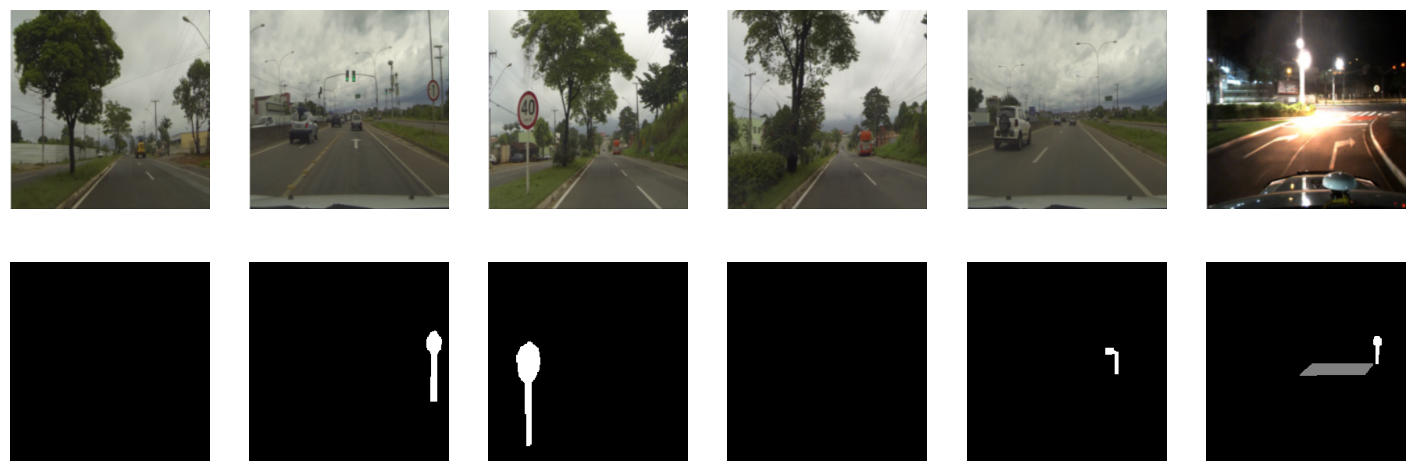

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = 100+i*10;
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[j])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[j].squeeze(), cmap='gray')
plt.show();

In [ ]:
XX = np.transpose(X[0:3000:3], axes=(0, 3, 1, 2))
YY = np.transpose(Y[0:3000:3], axes=(0, 3, 1, 2))

print(XX.shape)
print(YY.shape)

(1000, 3, 256, 256)
(1000, 1, 256, 256)


Let's check what values are present in the mask

In [ ]:
unique, counts = np.unique(YY, return_counts=True)
print(unique, counts)

[0 1 2] [62570586  2697615   267799]


It contains the following values

* 0 - background
* 1 - road sign
* 2 - crosswalk markings

We will solve the problem of binary segmentation, ie do one mask and for road signs, for this we need to have 1 to road signs and crosswalk markings.


In [ ]:
YY_r = np.where(YY > 0, 1, 0)
unique, counts = np.unique(YY_r, return_counts=True)
print(unique, counts)

[0 1] [62570586  2965414]


In [ ]:
print(2697615+267799)

2965414


Let's check what values are present in the mask now. The number of zeros should not change, and the number of "ones" should be equal to the sum of the number of ones and twos in the masks before the transformation.

In [ ]:
unique, counts = np.unique(YY, return_counts=True)
print(unique, counts)

[0 1 2] [62570586  2697615   267799]


Translate the pixel values of the image into the range [0;1]

In [ ]:
print(np.max(XX), np.min(XX))

255 0


In [ ]:
XXX = np.array(XX / 255, dtype='float32')
YYY = np.array(YY_r, dtype='float32')

print(XXX.shape)
print(YYY.shape)

(1000, 3, 256, 256)
(1000, 1, 256, 256)


Normalizing pixel values

In [ ]:
X_t = torch.FloatTensor(XXX)
Y_t = torch.FloatTensor(YYY)

for x in X_t:
  transforms.functional.normalize(x, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225), inplace=True)

print(X_t.shape)
print(X_t[0])

torch.Size([1000, 3, 256, 256])
tensor([[[ 1.5297,  1.0673,  0.9474,  ...,  1.2385,  1.1872,  0.8618],
         [ 1.8379,  1.3242,  1.1872,  ...,  1.4783,  1.4440,  1.1700],
         [ 1.8379,  1.3242,  1.1872,  ...,  1.4612,  1.4783,  1.2214],
         ...,
         [ 1.8379, -0.2171, -1.1075,  ..., -1.0219, -1.0390, -1.1418],
         [ 1.8379, -0.2171, -1.1247,  ..., -1.0562, -1.0733, -1.1760],
         [ 1.5297, -0.4054, -1.2788,  ..., -1.2445, -1.2445, -1.3302]],

        [[ 1.6933,  1.2556,  1.1506,  ...,  1.4482,  1.3957,  1.0455],
         [ 2.0084,  1.5357,  1.4132,  ...,  1.6933,  1.6583,  1.3782],
         [ 2.0084,  1.5357,  1.4132,  ...,  1.6758,  1.6933,  1.4132],
         ...,
         [ 2.0084, -0.0749, -0.9678,  ..., -0.9328, -0.9503, -1.0553],
         [ 2.0084, -0.0749, -0.9853,  ..., -0.9678, -0.9853, -1.0903],
         [ 1.6933, -0.2850, -1.1604,  ..., -1.1604, -1.1604, -1.2479]],

        [[ 1.9080,  1.4200,  1.2980,  ...,  1.5594,  1.4897,  1.1585],
         [ 2.

Let's divide 1000 pictures by 700/150/150 for training, validation and test respectively.

In [ ]:
ix = np.random.choice(len(XX), len(XX), False)
tr, val, ts = np.split(ix, [700, 850])

In [ ]:
print(len(tr), len(val), len(ts))

700 150 150


Create dataloaders

In [ ]:
X_train_t = X_t[tr]
Y_train_t = Y_t[tr]
X_val_t = X_t[val]
Y_val_t = Y_t[val]
X_test_t = X_t[ts]
Y_test_t = Y_t[ts]

train_dataset = TensorDataset(X_train_t, Y_train_t)
val_dataset = TensorDataset(X_val_t, Y_val_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
loaders = {
    'train': train_dataloader,
    'valid': val_dataloader
}

-----

Below is a function for displaying pictures that have been normalized and stored in tensors.

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Display one of the pictures after normalization to make sure all is correct

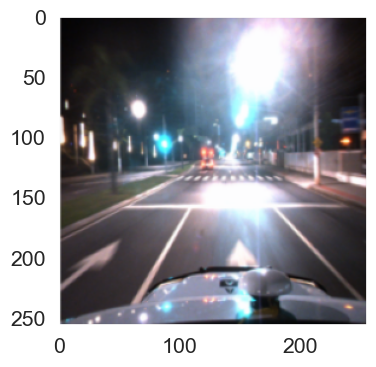

In [ ]:
item = next(iter(train_dataloader))[0]
imshow(item[0])

# Task 2. Set up a model



You must build a network yourself

In [ ]:
class SegNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.enc_conv0 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels = 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels = 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)

    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels = 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels = 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)

    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels = 256, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels = 256, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels = 256, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)

    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )
    self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)

    self.enc_conv4 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )
    self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True)

    self.upsample0 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
    self.dec_conv0 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.upsample1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 512, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels = 256, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels = 256, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels = 256, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels = 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
    self.dec_conv3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels = 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels = 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.upsample4 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
    self.dec_conv4 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels = 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels = 1, kernel_size = 3, padding = 1)
    )

  def forward(self, x):
    #encoder
    x, indices0 = self.pool0(self.enc_conv0(x))
    x, indices1 = self.pool1(self.enc_conv1(x))
    x, indices2 = self.pool2(self.enc_conv2(x))
    x, indices3 = self.pool3(self.enc_conv3(x))
    x, indices4 = self.pool4(self.enc_conv4(x))
    #decoder
    x = self.dec_conv0(self.upsample0(x, indices4))
    x = self.dec_conv1(self.upsample1(x, indices3))
    x = self.dec_conv2(self.upsample2(x, indices2))
    x = self.dec_conv3(self.upsample3(x, indices1))
    y = self.dec_conv4(self.upsample4(x, indices0))

    return y



## Metric

As a metric we will use the ratio of intersection to union of the masks, more details can be found
[here](https://www.jeremyjordan.me/evaluating-image-segmentation-models/).

The metric according to the definition is calculated as follows
$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$



![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

To avoid dividing by 0, a small positive number is added to the numerator and denominator.

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    return iou

Let's test the function

In [ ]:
outputs = torch.FloatTensor([[[1., 0.], [0., 1.]], [[1., 0.], [0., 1.]]])
oposite = torch.FloatTensor([[[0., 1.], [1., 0.]], [[0., 1.], [1., 0.]]])
intersected = torch.FloatTensor([[[1., 1.], [0., 1.]], [[1., 1.], [0., 1.]]])

print('iou_pytorch(outputs, outputs)', iou_pytorch(outputs, outputs).mean().item())
print('iou_pytorch(oposite, oposite)', iou_pytorch(oposite, oposite).mean().item())
print('iou_pytorch(intersected, intersected)', iou_pytorch(intersected, intersected).mean().item())

print('iou_pytorch(outputs, oposite)', iou_pytorch(outputs, oposite).mean().item())
print('iou_pytorch(outputs, intersected)', iou_pytorch(outputs, intersected).mean().item())
print('iou_pytorch(oposite, intersected)', iou_pytorch(oposite, intersected).mean().item())

iou_pytorch(outputs, outputs) 1.0
iou_pytorch(oposite, oposite) 1.0
iou_pytorch(intersected, intersected) 1.0
iou_pytorch(outputs, oposite) 2.4999999848063226e-09
iou_pytorch(outputs, intersected) 0.6666666865348816
iou_pytorch(oposite, intersected) 0.25


# Task 3. Train function

Write a learning function that outputs after each epoch of six validation dataset images, predicted masks and real masks, metric and loss function values.

In [ ]:
def train(name, model, optimizer, loss_fn, metric_fn, epochs, loaders):
    losses = {"train": [], "valid": []}
    scores = {"train": [], "valid": []}

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        for stage, dataloader in loaders.items():
            avg_loss = 0
            avg_score = 0

            if stage == 'train':
                model.train()
            else:
                model.eval()

            for X_batch, Y_batch in dataloader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                if stage == 'train':
                    # add code to train your model
                    optimizer.zero_grad()
                    Y_lg = model(X_batch)
                    loss = loss_fn(Y_lg, Y_batch)
                    loss.backward()  #gradient
                    optimizer.step()

                else:
                    with torch.no_grad():
                        # add code to predict logits and calc losses
                        Y_lg= model(X_batch).detach()
                        loss = loss_fn(Y_lg, Y_batch)

                # calculate score and loss to show the user
                Y_pred = torch.round(torch.sigmoid(Y_lg.detach()))
                score = metric_fn(Y_pred, Y_batch).mean().item()

                avg_loss += loss.detach().cpu().numpy() / len(dataloader)
                avg_score += score / len(dataloader)

                # clean GPU memory
                X_batch = X_batch.cpu()
                Y_batch = Y_batch.cpu()
                Y_lg = Y_lg.cpu()
                Y_pred = Y_pred.cpu()
                torch.cuda.empty_cache()

            losses[stage].append(avg_loss)
            scores[stage].append(avg_score)

        if stage == 'valid':
            # add code to show intermediate results
            plot_example(X_batch, Y_batch, Y_pred, f"epoch {epoch + 1}, avg_loss = {avg_loss}, avg_score = {avg_score}")

    return losses, scores

# Task 4. Training

In [ ]:
def plot_example(X, Y_val, Y_hat, suptitle):
    # Visualize tools
    clear_output(wait=True)
    for k in range(6):
        plt.rcParams["figure.figsize"] = (15,8)
        plt.subplot(3, 6, k+1)
        plt.imshow(np.rollaxis(X[k].numpy(), 0, 3), cmap='gray')
        plt.title('Photo')
        plt.axis('off')

        plt.subplot(3, 6, k+7)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Y_hat')
        plt.axis('off')

        if Y_val != None:
          plt.subplot(3, 6, k + 13)
          plt.imshow(Y_val[k, 0], cmap='gray')
          plt.title('Y_real')
          plt.axis('off')


    plt.suptitle(suptitle)
    plt.show()

    return plt

Train your model

In [ ]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer)

loss = nn.BCEWithLogitsLoss()
max_epochs = 100

In [ ]:
losses, scores = train("SegNet", model, optimizer, loss, iou_pytorch, max_epochs, loaders)

* Epoch 1/100


KeyboardInterrupt: 

Let's plot the value of the metric and the loss function

In [ ]:
def plot_losses_scores(losses, scores, epochs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), losses['train'], label='Train Loss')
    plt.plot(range(1, epochs + 1), losses['valid'], label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), scores['train'], label='Train Score')
    plt.plot(range(1, epochs + 1), scores['valid'], label='Valid Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Score over Epochs')
    plt.legend()

    plt.show()

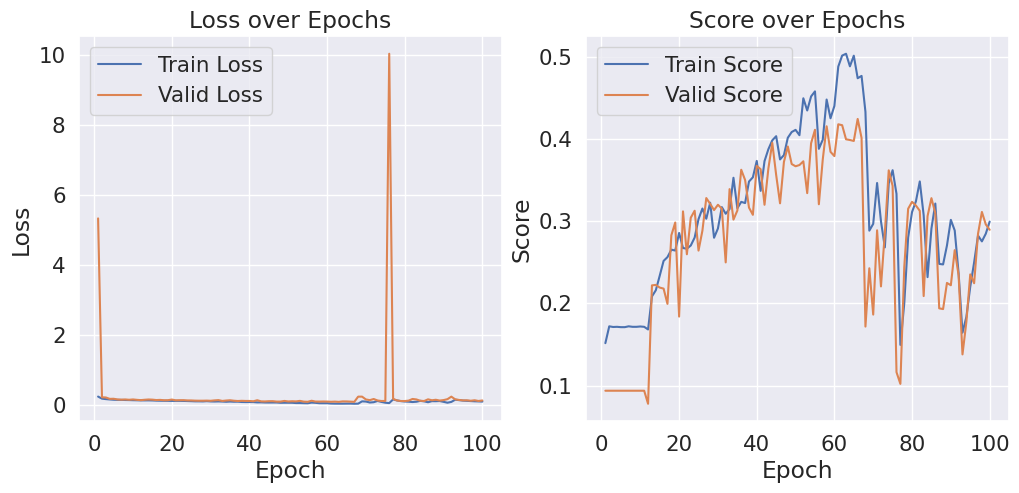

In [ ]:
plot_losses_scores(losses, scores, max_epochs)

Calculate the IoU metrics on the training, validation, and test datasets, and analyze their values.

In [ ]:
@torch.no_grad()
def predict(dataloader, model, is_vis=False):

    model.eval()
    predictions = np.array([])
    y_target = np.array([])

    for X_batch, Y_batch in dataloader:
        y_target = np.hstack((y_target, Y_batch.numpy().flatten()))
        X_batch = X_batch.to(device)

        Y_lg = model(X_batch)

        Y_pred = torch.round(torch.sigmoid(Y_lg.detach())).cpu()

        predictions = np.hstack((predictions, Y_pred.numpy().flatten()))
        X_batch = X_batch.cpu()

        Y_lg = Y_lg.cpu()
        Y_pred = Y_pred.cpu()

    model.train()
    if is_vis:
        plot_example(X_batch, Y_batch, Y_pred, 'Prediction visualization')

    return predictions, y_target

In [ ]:
Y_pred_train, Y_target_train = predict(train_dataloader, model)
Y_pred_val, Y_target_val = predict(val_dataloader, model)
Y_test_pred, Y_test_target = predict(test_dataloader, model)

In [ ]:
#IoU for training dataset
intersection_train = np.logical_and(Y_target_train, Y_pred_train)
union_train = np.logical_or(Y_target_train, Y_pred_train)
iou_score_train = np.sum(intersection_train) / np.sum(union_train)
print(iou_score_train)

0.39002408185875237


In [ ]:
#IoU for test dataset
intersection_test = np.logical_and(Y_test_target, Y_test_pred)
union_test = np.logical_or(Y_test_target, Y_test_pred)
iou_score_test = np.sum(intersection_test) / np.sum(union_test)
print(iou_score_test)

0.27307148974370976


In [ ]:
#IoU for validation dataset
intersection_val = np.logical_and(Y_target_val, Y_pred_val)
union_val = np.logical_or(Y_target_val, Y_pred_val)
iou_score_val = np.sum(intersection_val) / np.sum(union_val)
print(iou_score_val)

0.40692652382680317


What can you say?

....

# Task 5. Vizualization

Display 6 random pictures, and predicted and target masks, IoU score between predicted and target mask for each picture.

In [ ]:
import random
# будем визуализировать результаты работы модели на тестовом наборе данных
def visualize_results(model, dataloader, device, num_images=6):
    model.eval()
    images, true_masks, pred_masks, iou_scores = [], [], [], []

    with torch.no_grad():
        for X_batch, Y_batch in dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            Y_pred = model(X_batch)
            Y_pred = torch.round(torch.sigmoid(Y_pred))

            iou = iou_pytorch(Y_pred, Y_batch).mean().item()

            images.extend(X_batch.cpu())
            true_masks.extend(Y_batch.cpu())
            pred_masks.extend(Y_pred.cpu())
            iou_scores.append(iou)

            if len(images) >= num_images:
                break

    # Отображение результатов
    plt.figure(figsize=(18, 12))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        imshow(images[i])
        plt.title("Input Image")

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title("True Mask")

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask\nIoU: {iou_scores[i]:.4f}")

    plt.tight_layout()
    plt.show()

# Визуализация результатов на тестовом наборе данных для модели без scheduler на оригинальных данных
print("Visualizing results for model without scheduler on original data:")
visualize_results(model, test_dataloader, device)

# Визуализация результатов на тестовом наборе данных для модели без scheduler на аугментированных данных
print("Visualizing results for model without scheduler on augmented data:")
visualize_results(model, augmented_test_dataloader, device)

## Визуализация результатов на тестовом наборе данных для модели с scheduler на оригинальных данных
#print("Visualizing results for model with scheduler on original data:")
#visualize_results(model, test_dataloader, device)
#
## Визуализация результатов на тестовом наборе данных для модели с scheduler на аугментированных данных
#print("Visualizing results for model with scheduler on augmented data:")
#visualize_results(model, augmented_test_dataloader, device)


: 

In [ ]:
# на валидационном

def visualize_results(model, dataloader, device, num_images=6):
    model.eval()
    images, true_masks, pred_masks, iou_scores = [], [], [], []

    with torch.no_grad():
        for X_batch, Y_batch in dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            Y_pred = model(X_batch)
            Y_pred = torch.round(torch.sigmoid(Y_pred))

            iou = iou_pytorch(Y_pred, Y_batch).mean().item()

            images.extend(X_batch.cpu())
            true_masks.extend(Y_batch.cpu())
            pred_masks.extend(Y_pred.cpu())
            iou_scores.append(iou)

            if len(images) >= num_images:
                break

    # Отображение результатов
    plt.figure(figsize=(18, 12))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        imshow(images[i])
        plt.title("Input Image")

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title("True Mask")

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask\nIoU: {iou_scores[i]:.4f}")

    plt.tight_layout()
    plt.show()

# Визуализация результатов на валидационном наборе данных для модели без scheduler на оригинальных данных
print("Visualizing results for model without scheduler on original data (Validation Set):")
visualize_results(model, val_dataloader, device)

# Визуализация результатов на валидационном наборе данных для модели без scheduler на аугментированных данных
print("Visualizing results for model without scheduler on augmented data (Validation Set):")
visualize_results(model, augmented_val_dataloader, device)

## Визуализация результатов на валидационном наборе данных для модели с scheduler на оригинальных данных
#print("Visualizing results for model with scheduler on original data (Validation Set):")
#visualize_results(model, val_dataloader, device)
#
## Визуализация результатов на валидационном наборе данных для модели с scheduler на аугментированных данных
#print("Visualizing results for model with scheduler on augmented data (Validation Set):")
#visualize_results(model, augmented_val_dataloader, device)

: 

# Submission

Congratulations, you almost made it! Now you should check and submit your work.

Please check that your Colab Notebook meets the following requirements:
1. The work is independently completed, and you have figured out the copied code. Good practices are:
  - Having links to resources where the code was taken from,
  - having comments in the code.
2. Conclusions are well-reasoned and valid.
3. The code is executable and the results reproducible. If the data is taken from your personal google drive, a link to the data is provided.
4. Colab Notebook contains the results of code execution in cell outputs.
5. The main structure of this Colab Notebook is preserved, all task results are explicitly marked.

To pass the lab you should send the sharing link to your Colab Notebook via [Google Form](https://docs.google.com/forms/d/e/1FAIpQLSduYTm8gqbIYQDuRiWZwZSrC-NkWI_DxrU0xkyPteCiTboXvg/viewform).

If you want continue your work, make a copy of the notebook. The deadline date will be comparing with the last modification date of your notebook (you should not modify the notebook after you submit it).

**Deadlines:**
- Soft – 14.05 23:59:59
- Hard – 17.05 23:59:59